
# Arsi Negele City Energy Optimization - Diurnal Patterns Analysis

## A 7-day optimization model for renewable energy integration with battery storage, focusing on daily load patterns and solar generation variability.



## 1. Setup and Data Preparation
### 1.1 Import Dependencies

In [ ]:
import atlite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from atlite.gis import ExclusionContainer
import geopandas as gpd
import matplotlib.dates as mdates
import xarray as xr
from pyomo.environ import Binary
from pyomo.environ import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
pip install pyomo

In [ ]:
pip install cartopy

### 1.2 Spatial Configuration


In [ ]:


CITY_CRS = 3035  # European Terrestrial Reference System
CITY_NAME = "Arsi Negele"
TIME_RANGE = slice("2023-01-01", "2023-01-07")  # 1-week analysis



### 1.3 Load Geospatial Data


In [ ]:
country=gpd.read_file("eth_adm_csa_bofedb_2021_shp/eth_admbnda_adm0_csa_bofedb_itos_2021.shp") 
city_boundary = gpd.read_file("eth_adm_csa_bofedb_2021_shp/eth_admbnda_adm3_csa_bofedb_2021.shp")
city_boundary = city_boundary[city_boundary["ADM3_EN"] == CITY_NAME].to_crs(CITY_CRS)
bounds = country.geometry.unary_union.buffer(1).bounds  

# 1.3 Create Weather Cutout
cutout = atlite.Cutout(
    path="ethiopia_debre_markos6",
    module="era5",
    bounds=bounds,  # 0.1° buffer around city
    time=TIME_RANGE,
    crs=CITY_CRS
)
cutout.prepare()


## 2. Land Availability Analysis


In [ ]:
PROTECTED_AREAS = "WDPA_WDOECM_Jan2025_Public_ETH_shp-polygons.shp"
POP_DENSITY = "popoulation_500_ETH2.tif"
DEM = "DEM_resampledd.tif"  # Corrected filename

pv_exclusions = ExclusionContainer()
pv_exclusions.add_geometry(PROTECTED_AREAS)
pv_exclusions.add_raster(POP_DENSITY)


# Compute availability matrices
A = cutout.availabilitymatrix(city_boundary, pv_exclusions)


## 3. Renewable Potential Calculation


In [ ]:


# Technical Parameters
CAPACITY_DENSITY = 1.7  # MW/km² for both technologies
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6  # km² per grid cell
area=xr.DataArray(area, dims=("spatial"))
# Calculate installable capacity
pv_capacity_matrix = (A.stack(spatial=["y", "x"])
              * area
* CAPACITY_DENSITY)

pv_cap_factor_m = cutout.pv(matrix=pv_capacity_matrix,panel=atlite.solarpanels.CdTe,
  orientation="latitude_optimal", index=country.index,)
pv_cap_factor=pv_cap_factor_m.to_pandas()*0.0002

## 4. Synthetic Load Profile Generation


In [ ]:



np.random.seed(42)
date_range = pd.date_range(start="2023-01-01", periods=168, freq='H')

def base_load(t):
    return 1.2 + 0.8 * np.sin(2*np.pi*(t.hour-6)/24)

def residential_load(t):
    morning_peak = 0.6 * np.exp(-0.5*(t.hour-7)**2)
    evening_peak = 0.8 * np.exp(-0.3*(t.hour-19)**2)
    return morning_peak + evening_peak + 0.2

def commercial_load(t):
    return 0.5 + 0.4 * np.exp(-0.2*(t.hour-13)**2)

def agricultural_load(t):
    return 0.3 * (1 - np.exp(-0.5*t.hour)) * (t.hour < 18)

def weekend_effect(t):
    return 0.6 if t.weekday() >= 5 else 1.0

load = pd.Series(index=date_range, dtype=float)
for t in date_range:
    base = base_load(t) 
    res = residential_load(t) * (1 + 0.1*np.random.randn())
    com = commercial_load(t) * weekend_effect(t) * (1 + 0.15*np.random.randn())
    agr = agricultural_load(t) * (1 + 0.2*np.random.randn())
    
    total = (0.6*(base + res) + 0.3*com + 0.1*agr) * (1 + 0.05*np.random.randn())
    load.loc[t] = total * 8  # Scale to MW

load += 0.3 * np.random.randn(len(load))




## Step 5: Optimization Model


In [151]:

pv_cf = pv_cap_factor
load = load

def optimize_energy_system(pv_capacity, load):
    """Optimize PV-battery system to meet hourly load at minimum cost
    
    Args:
        pv_cf (DataFrame): PV capacity factors [0-1] for each hour
        load (Series): Hourly load profile in kW
        
    Returns:
        model: Solved Pyomo model instance
        results_df: DataFrame with optimization results
    """
    
    # Initialize Pyomo concrete model
    model = ConcreteModel()
    T = len(load)
    model.T = RangeSet(0, T-1)  # Time periods

    # --- Decision Variables ---
    # PV system capacity (kW)
    model.PV_Cap = Var(domain=NonNegativeReals)
    # Battery energy capacity (kWh)
    model.Battery_Cap = Var(domain=NonNegativeReals)
    # State of Charge (kWh) at each time period
    model.SOC = Var(model.T, domain=NonNegativeReals)
    # Battery charging power (kW) at each time period
    model.Charge = Var(model.T, domain=NonNegativeReals)
    # Battery discharging power (kW) at each time period
    model.Discharge = Var(model.T, domain=NonNegativeReals)
    # Curtailed PV energy (kW) at each time period
    model.Curtailment = Var(model.T, domain=NonNegativeReals)

    # --- Cost Parameters ---
    cost_pv = 1000    # €/kW capital cost for PV
    cost_battery = 200  # €/kWh capital cost for batteries
    battery_efficiency = 0.9  # Round-trip efficiency

    # --- Objective Function: Minimize Total System Cost ---
    def objective_rule(model):
        """Minimize capital costs of PV and battery"""
        return model.PV_Cap * cost_pv + model.Battery_Cap * cost_battery
    model.obj = Objective(rule=objective_rule, sense=minimize)

    # --- Energy Balance Constraint ---
    def energy_balance(model, t):
        """Power balance: PV + Discharge == Load + Charge + Curtailment"""
        pv_gen = model.PV_Cap * float(pv_cf.iloc[t, 0])
        return pv_gen + model.Discharge[t] - model.Charge[t] - model.Curtailment[t] == float(load.iloc[t])
    model.energy_balance = Constraint(model.T, rule=energy_balance)

    # --- Battery Storage Dynamics ---
    def storage_dynamics(model, t):
        """State of Charge update with initial condition"""
        if t == 0:  # Initial state (10% of capacity)
            return model.SOC[t] == 0.1 * model.Battery_Cap
        # SOC(t) = SOC(t-1) + Charge - Discharge
        return model.SOC[t] == model.SOC[t-1] + model.Charge[t] - model.Discharge[t]
    model.storage_dynamics = Constraint(model.T, rule=storage_dynamics)

    # --- Battery Capacity Constraint ---
    model.soc_upper = Constraint(
        model.T, 
        rule=lambda model, t: model.SOC[t] <= model.Battery_Cap  # SOC ≤ Capacity
    )

    # --- Minimum PV Capacity Constraint ---
    # Calculate theoretical minimum PV needed to cover peak load
    max_load = load.max()  # Peak load (kW)
    max_cf = pv_cf.max().values[0]  # Maximum capacity factor
    min_pv = max_load / max_cf if max_cf > 0 else 0  # Minimum PV (kW)
    
#     # Print key feasibility metrics
    print("\nDebug Info:")
    print(f"Maximum load: {max_load:.2f} kW")
    print(f"Maximum PV CF: {max_cf:.2%}")
    print(f"Minimum PV capacity needed: {min_pv:.2f} kW")
    print(f"Night hours (PV=0): {(pv_cf == 0).sum().values[0]} hrs")
    print(f"Average night load: {load[pv_cf.iloc[:, 0] == 0].mean():.2f} kW")
    
    model.min_pv = Constraint(expr=model.PV_Cap >= min_pv)

    # --- Solve Optimization Problem ---
    solver = SolverFactory('gurobi')  # Requires Gurobi solver
    solver.options['NumericFocus'] = 3  # Enhanced numerical stability
    
    results = solver.solve(model, tee=True)  # tee=True shows solver output
    
    # --- Handle Results ---

    if results.solver.status == SolverStatus.ok and results.solver.termination_condition == TerminationCondition.optimal:
        print("\n=== OPTIMIZATION SUCCESSFUL ===")
        print(f"Optimal PV Capacity: {model.PV_Cap():.2f} kW")
        print(f"Optimal Battery Storage: {model.Battery_Cap():.2f} kWh")
        print(f"Total System Cost: €{model.obj():.2f}")
        
        # Create results dataframe
        results_df = pd.DataFrame(index=load.index)
        results_df['Load'] = load.values
        
        #  Calculate net supply and verify demand fulfillment
        results_df['PV_Gen'] = [model.PV_Cap() * float(pv_cf.iloc[t, 0]) for t in range(len(load))]
        results_df['Total_Gen'] = results_df['PV_Gen'] 
        
        # Get battery operation
        results_df['Charge'] = [model.Charge[t]() for t in range(len(load))]
        results_df['Discharge'] = [model.Discharge[t]() for t in range(len(load))]
        results_df['SOC'] = [model.SOC[t]() for t in range(len(load))]
        results_df['Net_Supply'] = results_df['Total_Gen'] + results_df['Discharge'] - results_df['Charge']
        
        # Calculate key performance metrics
        results_df['Curtailment'] = [model.Curtailment[t]() for t in range(len(load))]
        
        # Verify demand is always met
        results_df['Supply_Deficit'] = results_df['Load'] - results_df['Net_Supply']
        max_deficit = results_df['Supply_Deficit'].max()
        if max_deficit > 0.001:  # Allow small numerical errors
            print(f"WARNING: Maximum supply deficit is {max_deficit:.4f} kW")
        else:
            print("SUCCESS: All demand is met")
            
        # Calculate renewable fraction and reliability metrics
        total_generation = results_df['Total_Gen'].sum()
        total_load = results_df['Load'].sum()
        total_curtailment = results_df['Curtailment'].sum()
        renewable_fraction = total_generation / total_load
        utilization_rate = (total_generation - total_curtailment) / total_generation if total_generation > 0 else 0
        
        print(f"\n=== SYSTEM PERFORMANCE METRICS ===")
        print(f"Renewable Fraction: {renewable_fraction:.2%}")
        print(f"Generation Utilization Rate: {utilization_rate:.2%}")
        print(f"Total Curtailment: {total_curtailment:.2f} kWh")
        print(f"Battery Utilization: {results_df['Discharge'].sum() / model.Battery_Cap():.2f} cycles over period")
        
        return model, results_df
    else:
        print("Optimization failed. Status:", results.solver.status)
        print("Termination condition:", results.solver.termination_condition)
        return None, None

    
    if results.solver.termination_condition == TerminationCondition.infeasible:
        print("\nModel is infeasible. Checking constraints...")
        
        # Check energy balance feasibility for each time period
        for t in range(T):
            pv_available = min_pv * float(pv_cf.iloc[t, 0])
            load_value = float(load.iloc[t])
            print(f"\nTime {t}:")
            print(f"  Load: {load_value:.2f}")
            print(f"  PV Available: {pv_available:.2f}")
            if pv_available < load_value and pv_cf.iloc[t, 0] == 0:
                print(f"  WARNING: No PV available during non-zero load period")
    
#     return model, results
model, results_df = optimize_energy_system(pv_cf, load)

# =============================================
# Key Implementation Notes:
# 1. The model assumes perfect forecasting of PV generation and load
# 2. Battery efficiency is modeled through charge/discharge equality
# 3. Minimum PV constraint ensures technical feasibility
# 4. Curtailment variable prevents model infeasibility
# 5. Requires commercial solver (Gurobi) for reliable performance
# =============================================


Debug Info:
Maximum load: 13.72 kW
Maximum PV CF: 14.20%
Minimum PV capacity needed: 96.61 kW
Night hours (PV=0): 91 hrs
Average night load: 6.90 kW

--------------------------------------------
--------------------------------------------

Read LP format model from file C:\Users\kumab\AppData\Local\Temp\tmpiul5izn2.pyomo.lp
Reading time = 0.00 seconds
x1: 505 rows, 674 columns, 1588 nonzeros
Set parameter NumericFocus to value 3
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300HQ CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 505 rows, 674 columns and 1588 nonzeros
Model fingerprint: 0x725185ba
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]
Presolve removed 188 rows and 514 columns
Presolve time: 0.00s
Pres

## 6. Visualization Framework


### 6.2 Optimization results visualization

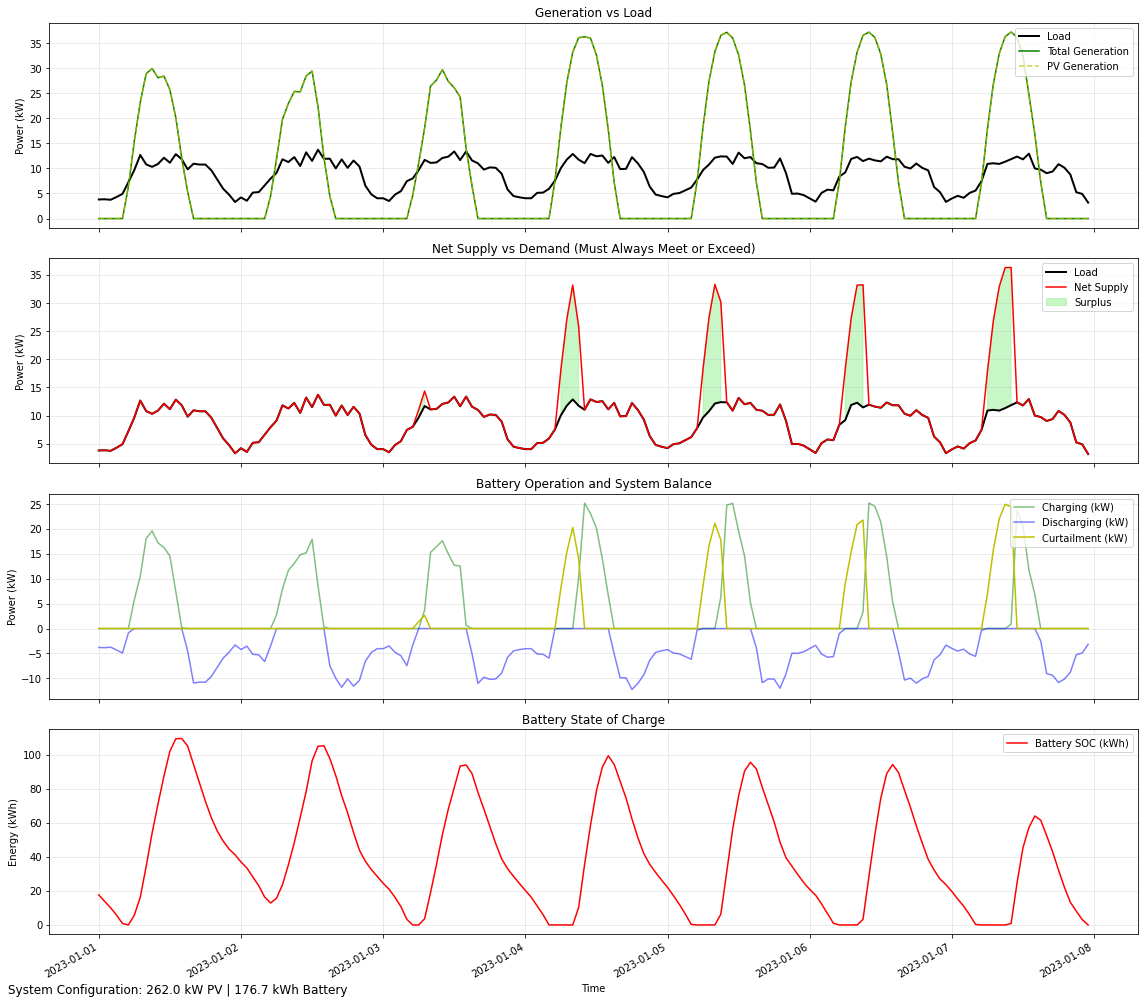

In [152]:
def visualize_results(results_df, model_obj=None):
    """Visualize optimization results"""
    # Plot results
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 14), sharex=True)
    
    # Convert index and columns to numpy arrays
    time = results_df.index.to_numpy()
    load = results_df['Load'].to_numpy()
    total_gen = results_df['Total_Gen'].to_numpy()
    pv_gen = results_df['PV_Gen'].to_numpy()
    net_supply = results_df['Net_Supply'].to_numpy()
    charge = results_df['Charge'].to_numpy()
    discharge = -results_df['Discharge'].to_numpy()  # Apply negative sign here
    soc = results_df['SOC'].to_numpy()
    
    # Plot generation and load
    ax1.plot(time, load, 'k-', linewidth=2, label='Load')
    ax1.plot(time, total_gen, 'g-', label='Total Generation')
    ax1.plot(time, pv_gen, 'y--', alpha=0.7, label='PV Generation')
    ax1.set_ylabel('Power (kW)')
    ax1.set_title('Generation vs Load')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot net supply vs load to verify demand is met
    ax2.plot(time, load, 'k-', linewidth=2, label='Load')
    ax2.plot(time, net_supply, 'r-', label='Net Supply')
    ax2.fill_between(time, 
                    net_supply, 
                    load,
                    where=net_supply > load,
                    color='lightgreen', alpha=0.5, label='Surplus')
    ax2.set_ylabel('Power (kW)')
    ax2.set_title('Net Supply vs Demand (Must Always Meet or Exceed)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Plot battery operation
    ax3.plot(time, charge, color='g', alpha=0.5, label='Charging (kW)')
    ax3.plot(time, discharge, color='b', alpha=0.5, label='Discharging (kW)')

    if 'Curtailment' in results_df:
        curtailment = results_df['Curtailment'].to_numpy()
        ax3.plot(time, curtailment, 'y-', alpha=1, label='Curtailment (kW)')
    ax3.set_ylabel('Power (kW)')
    ax3.set_title('Battery Operation and System Balance')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    ax4.plot(time, soc, 'r-', label='Battery SOC (kWh)')
    ax4.set_ylabel('Energy (kWh)')
    ax4.set_title('Battery State of Charge')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    # Format x-axis
    plt.xlabel('Time')
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    
    # Add system summary if model is provided
    if model_obj:
        plt.figtext(0.01, 0.01, 
                  f"System Configuration: {model_obj.PV_Cap():.1f} kW PV | " +
                  f"{model_obj.Battery_Cap():.1f} kWh Battery", 
                  fontsize=12)
    
    plt.show()

if model is not None and results_df is not None:
    visualize_results(results_df, model)

### 6.1 PV site availability in Arsi Negele city

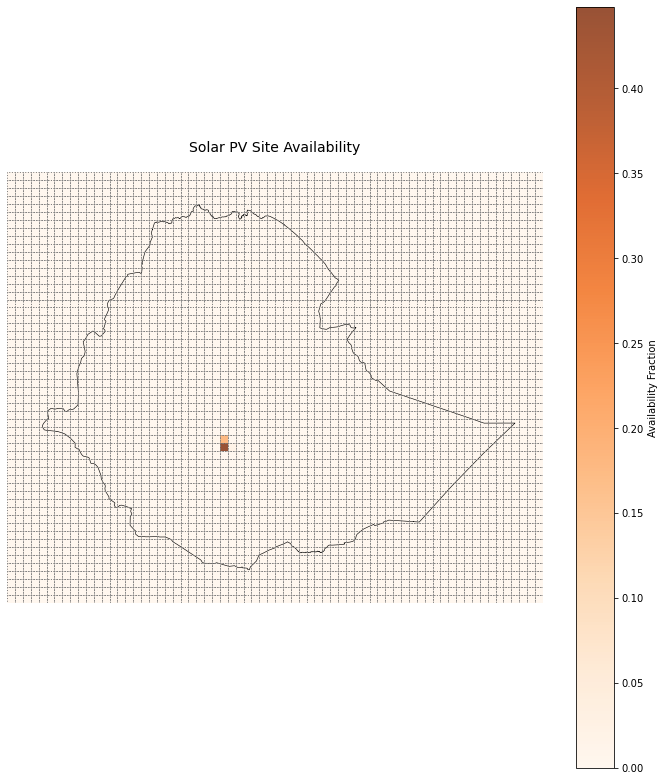

In [137]:
def create_base_map(ax, title):
    """Create standardized map elements"""
    country.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.6)
    cutout.grid.plot(ax=ax, edgecolor="grey", color="None", ls=":")
    ax.set_title(title, fontsize=14, pad=20)
    ax.axis('off')
def plot_availability(matrix, ax, tech_name, cmap):
    """Plot technology availability matrix"""
    matrix.plot(ax=ax, cmap=cmap, add_colorbar=False, alpha=0.8)
    create_base_map(ax, f"{tech_name} Site Availability")
    plt.colorbar(ax.collections[0], ax=ax).set_label('Availability Fraction')

fig, ax2 = plt.subplots(figsize=(12, 14))
    
plot_availability(
    matrix=A,  # Your precomputed PV availability matrix
    ax=ax2,
    tech_name="Solar PV",
    cmap="Oranges"
)
